<a href="https://www.kaggle.com/code/eduardoyanez/pepper-classifier?scriptVersionId=125412082" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Pepper classifier

This is an exercise for the lesson 2 of the fast.ai course to make a classifier of some type of peppers.

In [1]:
!pip install -Uqq fastai duckduckgo_search

In [2]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *
from fastai.vision.widgets import ImageClassifierCleaner

### Basic functions

There are to helper functions:
* search_images: For searching images in DuckDuckGo.
* predict: Call the learner for predicting the type of the pepper. 

In [3]:
def search_images(search_term, max_images=40):
    print(f"\nSearching for '{search_term}'")
    return L(ddg_images(search_term, max_results=max_images)).itemgot('image')

In [4]:
def predict(image):
    type_of_pepper,_,probs = learner.predict(image)
    print(f"This pepper is a: {type_of_pepper}.")
    print(f"Probability it is a {type_of_pepper}: {probs[0]:.4f}")

### Main program

Here it downloads pictures of several type of peppers (italian, morrón, padrón and jalapeño), and the images are store in folders named as the type of the pepper.

Also, the images are resized in order to save espace on disk.

In [5]:
search_terms = 'italian', 'morron', 'padron'
path = Path('pepper')

for search_term in search_terms:
    dest = (path/search_term)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{search_term} pepper'))
    resize_images(path/search_term, max_size=400, dest=path/search_term)


Searching for 'italian pepper'

Searching for 'morron pepper'


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:997: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "



Searching for 'padron pepper'


Now all images which couldn't be downloaded because of broken links are deleted.

In [6]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

2

### Data preparation

The data must be prepared to be useful to train the model. Dataloaders are created from DataBlocks.

As transformers, at the beginning I used random crops (RandomResizedCrop), but I think it causes the model to not be trained properly, because cropped parts of peppers are very similar even if the pepper is of a different type, so finally I chose ResizeMethod.Squish. Also, images are transformed in several ways using the _augmentation_ transformer function.

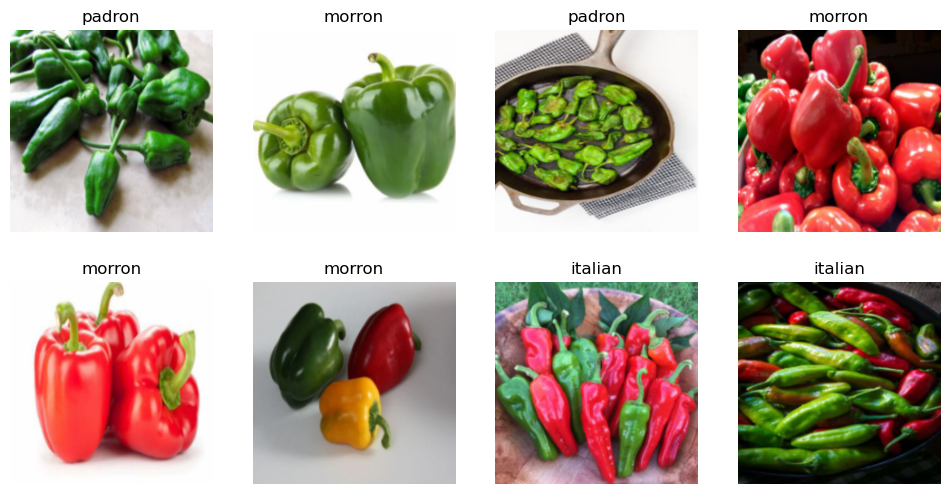

In [7]:
dataloaders = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=43),
    get_y=parent_label,
    item_tfms=Resize(224, ResizeMethod.Squish),
    batch_tfms=aug_transforms(mult=0.3)
).dataloaders(path)

dataloaders.show_batch(max_n=8)

Now the model is trained for the first time, before cleaning the data.

In [8]:
learner = vision_learner(dataloaders, resnet18, metrics=error_rate)
learner.fine_tune(5)

/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
/opt/conda/lib/python3.7/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,2.207121,4.802151,0.545455,00:03


epoch,train_loss,valid_loss,error_rate,time
0,1.802447,3.595751,0.545455,00:01
1,1.807515,2.466125,0.545455,00:00
2,1.517120,1.520099,0.500000,00:00
3,1.329067,1.070679,0.409091,00:01
4,1.195285,0.857966,0.363636,00:00


It seems that the model is not very accurate. I think it is diffcult to distinguish correctly the different type of peppers.

Let's see the confusion matrix to see what's happening:

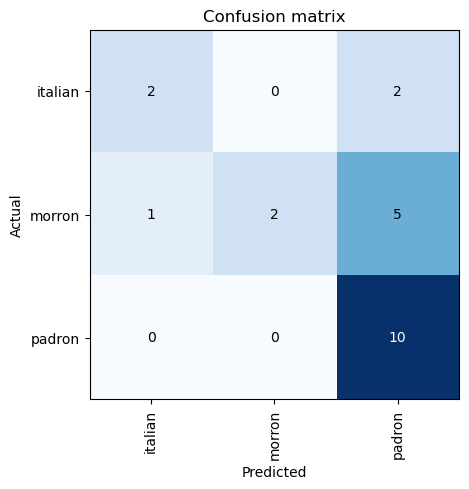

In [9]:
interpretation = ClassificationInterpretation.from_learner(learner)
interpretation.plot_confusion_matrix()

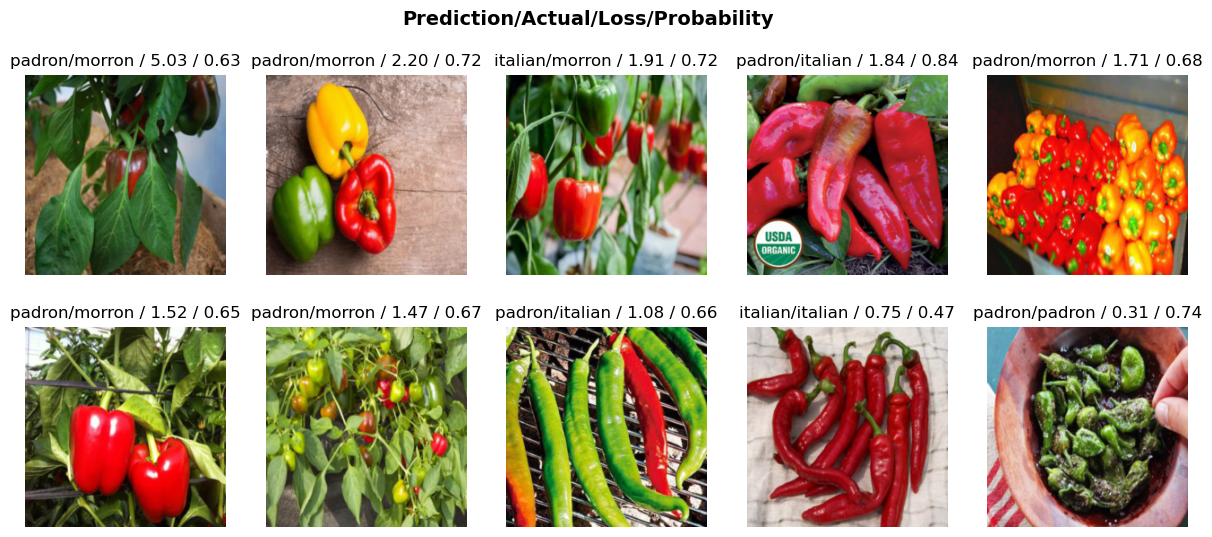

In [10]:
interpretation.plot_top_losses(10, nrows=2)

Let's try to clean the data using the ImageClassifierCleaner class.

In [11]:
cleaner = ImageClassifierCleaner(learner)
cleaner

In [12]:
for index in cleaner.delete():
    cleaner.fns[index].unlink()

for index,category in cleaner.change():
    shutil.move(str(cleaner.fns[index]), path/category)

### Training model after cleaning the data

Now that the data is a bit cleaner, the model can be trained again. Then, we export the model to a file so it can be used in another place.

In [13]:
learner.export('pepper-classifier-model.pkl')

### Conclusion

This model predicts quite well the morron & padron peppers, but it struggles when predicting Italian ones, it gets confused with padron peppers because the shape is very similar, and only the size changes, and that characteristic is very difficult to bear in mind from a picture.